In [2]:
from nltk import ConfusionMatrix
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

X, y = mnist.data, mnist.target
X.shape
y.shape

(70000,)

Matplotlib is building the font cache; this may take a moment.


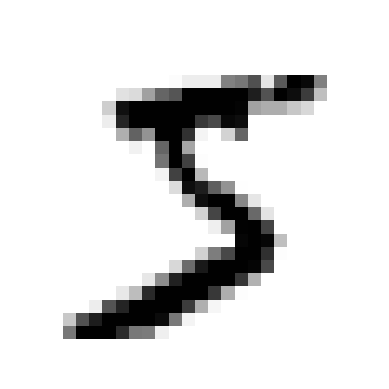

In [3]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [4]:
y[0]

'5'

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

note the slicing above; also realise that we basically immediately split the data into _test_ and _train_

## Binary Classification

In [7]:
y_train_5 = (y_train == '5') # these are the labels with 5
y_test_5 = (y_test == '5')

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [14]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
y_perf = y_train_5
confusion_matrix(y_train_5, y_perf)

array([[54579,     0],
       [    0,  5421]])

In [20]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [22]:
from sklearn.metrics import f1_score # the harmonic mean of the above 2 metrics
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Note that increasing precision reduces recall, and vice-versa

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [27]:
threshold = 0
y_some_digit_pred=(y_scores > threshold)
y_some_digit_pred

array([ True])

In [28]:
threshold = 3000
y_some_digit_pred=(y_scores > threshold)
y_some_digit_pred

array([False])

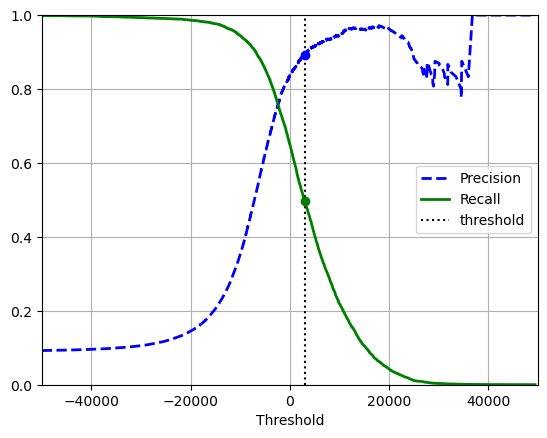

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold,0,1.0,"k","dotted",label="threshold")

idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
#save_fig("precision_recall_vs_threshold_plot")

plt.show()


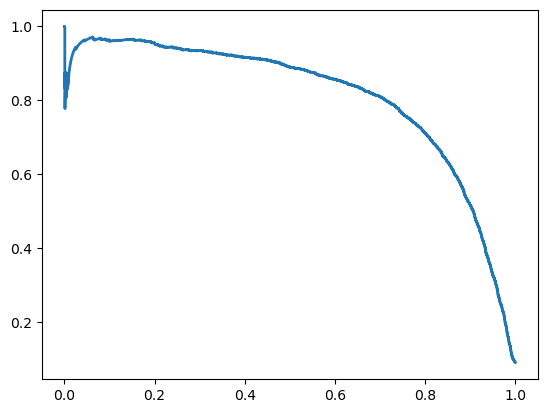

In [32]:
plt.plot(recalls,precisions,linewidth=2,label="Precision/Recall curve")

In [33]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [34]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [35]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [36]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

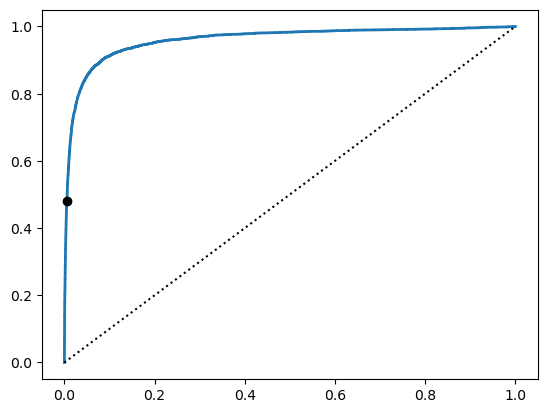

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0,1],[0,1],'k:',label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.show()

Analysis: in the above, the random Receiver Operating Characteristic (ROC) curve is the diagonal.
the ideal classifier would be maximally away from that line, yielding an AUC (area under curve) of 1
as opposed to 0.5

In [40]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_train_5, y_scores)
roc_auc

0.9604938554008616

In [41]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [42]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [43]:
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)


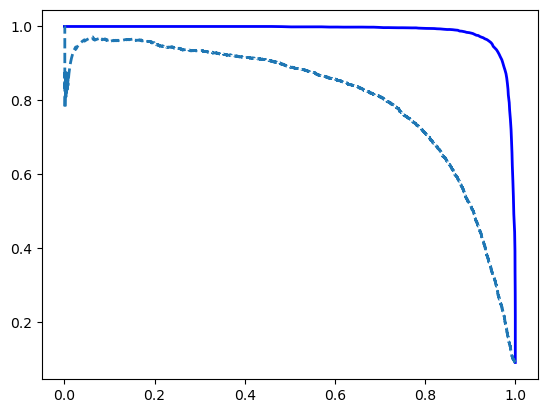

In [44]:
plt.plot(recalls_forest,precisions_forest,"b-",linewidth=2,label="Random Forest")
plt.plot(recalls,precisions,"--",linewidth=2,label="SGD")
plt.show()

In [46]:
y_train_pred_forest = y_probas_forest[:,1] >= 0.5
f1_score(y_train_5,y_train_pred_forest)

0.9274509803921569

In [47]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [48]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [49]:
recall_score(y_train_5, y_train_pred_forest)


0.8725327430363402

## Multiclass

In [50]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) 

SVC(random_state=42)

In [51]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [52]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [53]:
class_id = some_digit_scores.argmax()
class_id

5

In [54]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [55]:
svm_clf.classes_[class_id]

'5'

In [59]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [60]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [63]:
len(ovr_clf.estimators_)

10

In [64]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [65]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [66]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

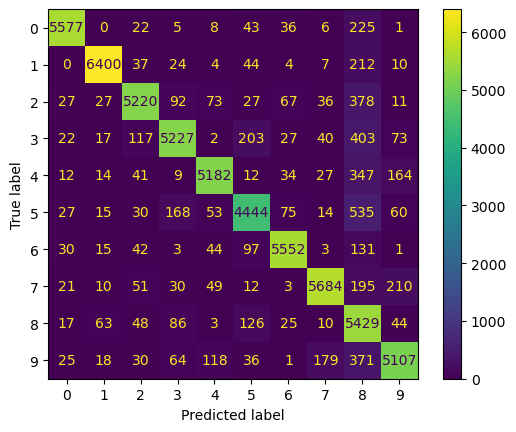

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred)
plt.show()

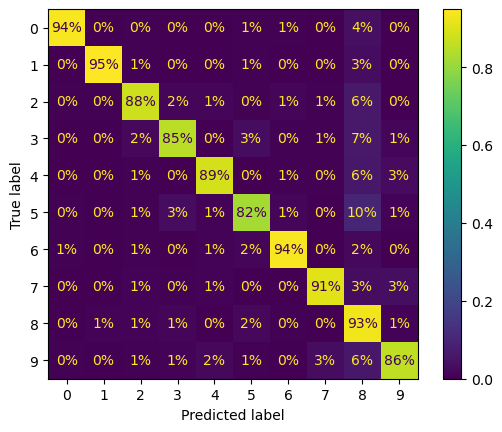

In [70]:
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,normalize="true",values_format=".0%")
plt.show()

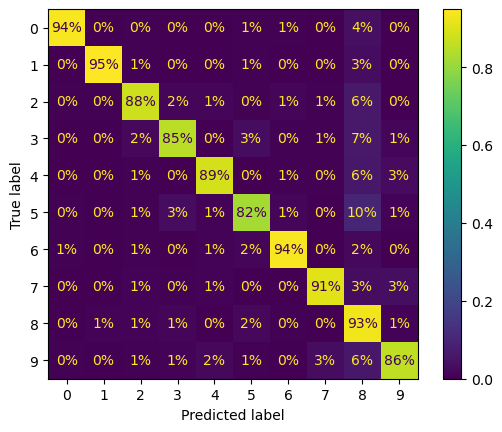

In [72]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,normalize="true",values_format=".0%")

## Multilabel Classification

In [73]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd =(y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [74]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [75]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

In [76]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [77]:
chain_clf.predict([some_digit])

array([[0., 1.]])

## Multioutput Classification

In [81]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train),784))
X_train_mod = X_train = noise
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

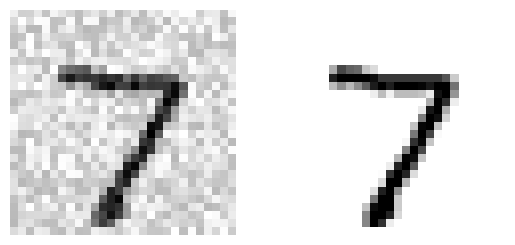

In [82]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()


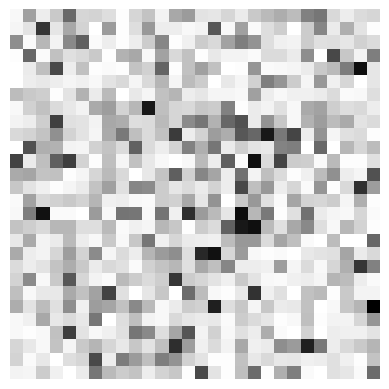

In [83]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()